# Baseline Embedding Analysis
**Temporal State Model - Burn/Sham Wound Healing**

Date: 2025-12-05  
Data: 57,298 cells × 3,000 genes  
Conditions: Burn (24,855 cells), Sham (32,443 cells)  
Timepoints: Day 10, 14, 19

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.verbosity = 1
sc.settings.set_figure_params(dpi=100, facecolor='white')

## 1. Data Preparation

In [2]:
# Load original data
adata_raw = sc.read_h5ad("filtered_final_sample_removed.h5ad")

print(f"Shape: {adata_raw.shape}")
print(f"\nOriginal columns: {adata_raw.obs.columns.tolist()[:10]}...")

Shape: (57298, 3000)

Original columns: ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample', 'Timepoint', 'Type', 'Type_Timepoint', 'mitoRatio', 'ident', 'scDblFinder.class']...


/home/scumpia-mrl/Desktop/Sujit/Projects/state-experimentation/.venv/lib/python3.11/site-packages/anndata/_io/h5ad.py:266: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  return AnnData(**{


In [3]:
# Add required columns
adata_raw.obs['condition'] = adata_raw.obs['Type']
adata_raw.obs['timepoint'] = adata_raw.obs['Timepoint'].map({'D10': 'day10', 'D14': 'day14', 'D19': 'day19'})
adata_raw.obs['time_days'] = adata_raw.obs['timepoint'].map({'day10': 10.0, 'day14': 14.0, 'day19': 19.0})
adata_raw.obs['cell_type'] = adata_raw.obs['cell_types_simple']
adata_raw.obs['mouse_id'] = adata_raw.obs['Sample']
adata_raw.obs['batch'] = adata_raw.obs['orig.ident']

# Convert gene names to uppercase for State model
adata_raw.var_names = [gene.upper() for gene in adata_raw.var_names]
adata_raw.var_names_make_unique()

# Remove raw data (causes save issues)
adata_raw.raw = None

print("\n✓ Added required columns and converted gene names")


✓ Added required columns and converted gene names


In [4]:
# Data breakdown
print("Cells per condition × timepoint:")
print(adata_raw.obs.groupby(['condition', 'timepoint']).size())

print("\nMice per condition:")
print(adata_raw.obs.groupby('condition')['mouse_id'].nunique())

Cells per condition × timepoint:
condition  timepoint
Burn       day10         8904
           day14         7393
           day19         8558
Sham       day10         7573
           day14        13797
           day19        11073
dtype: int64

Mice per condition:
condition
Burn    8
Sham    7
Name: mouse_id, dtype: int64


In [5]:
# Save processed data
adata_raw.write_h5ad("burn_sham_processed_uppercase.h5ad")
print("✓ Saved to burn_sham_processed_uppercase.h5ad")

✓ Saved to burn_sham_processed_uppercase.h5ad


## 2. Extract State Embeddings

**Run in terminal:**
```bash
uv run state emb transform \
  --model-folder models/SE-600M \
  --checkpoint models/SE-600M/se600m_epoch16.ckpt \
  --config models/SE-600M/config.yaml \
  --input burn_sham_processed_uppercase.h5ad \
  --output burn_sham_baseline_embedded.h5ad \
  --embed-key X_state_baseline \
  --batch-size 32
```

Expected: 2,721/3,000 genes (90.7%) matched  
Time: ~30 minutes on GPU

## 3. Load Embedded Data

In [13]:
# Load embedded data
adata = sc.read_h5ad("burn_sham_baseline_embedded.h5ad")

print(f"Shape: {adata.shape}")
print(f"Embeddings: {list(adata.obsm.keys())}")
print(f"State embedding shape: {adata.obsm['X_state_baseline'].shape}")

Shape: (57298, 3000)
Embeddings: ['X_harmony', 'X_pca', 'X_state_baseline', 'X_umap']
State embedding shape: (57298, 2058)


## 4. UMAP Visualization

In [ ]:
# Compute neighbors and UMAP from State embeddings
sc.pp.neighbors(adata, use_rep='X_state_baseline', n_neighbors=15,  n_pcs=)
sc.tl.umap(adata, n_components=)

/home/scumpia-mrl/Desktop/Sujit/Projects/state-experimentation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Computed neighbors and UMAP


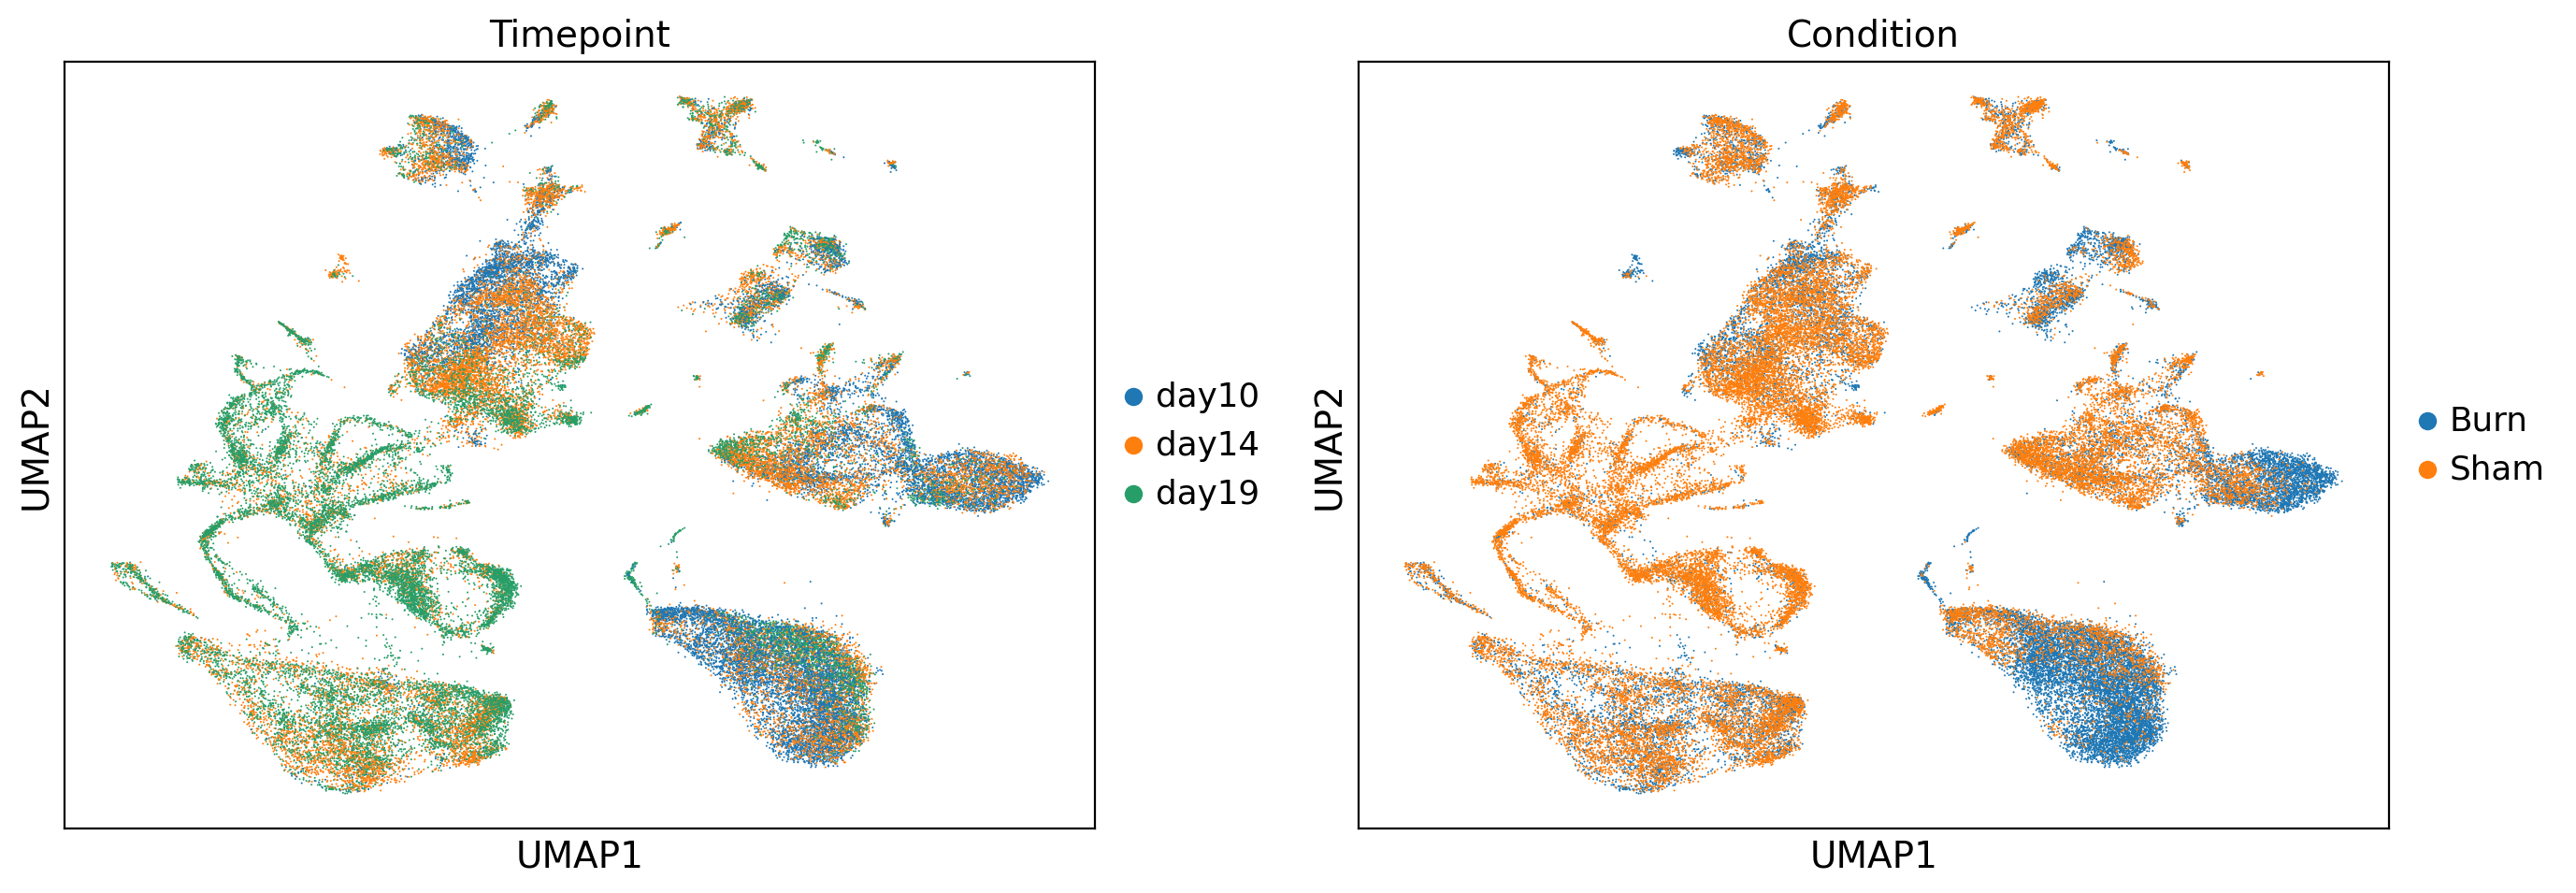

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sc.pl.umap(adata, color='timepoint', ax=axes[0], show=False, title='Timepoint')
sc.pl.umap(adata, color='condition', ax=axes[1], show=False, title='Condition')

plt.tight_layout()
#plt.savefig('baseline_umap_SE.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Baseline Metrics

In [5]:
# Cell type classification accuracy (kNN)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

X = adata.obsm['X_state_baseline']
y = adata.obs['cell_type'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\n=== Cell Type Classification (kNN) ===")
print(f"Accuracy: {acc:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))


=== Cell Type Classification (kNN) ===
Accuracy: 0.964

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93      1877
           1       0.99      0.99      0.99      3354
           2       0.97      0.98      0.98      3390
           3       0.98      0.95      0.97       704
           4       0.88      0.79      0.83       679
           5       0.83      0.59      0.69       506
           6       0.97      0.99      0.98       371
           7       0.97      0.98      0.98       609
           8       0.99      0.99      0.99      5574
           9       0.91      1.00      0.96        32
          10       0.88      0.98      0.92        94

    accuracy                           0.96     17190
   macro avg       0.93      0.93      0.93     17190
weighted avg       0.96      0.96      0.96     17190



In [ ]:
# Batch effect (mouse-to-mouse variation)
from sklearn.metrics import silhouette_score

# Silhouette score (higher = more separated by batch, worse)
batch_silhouette = silhouette_score(X, adata.obs['mouse_id'], metric='cosine')
celltype_silhouette = silhouette_score(X, adata.obs['cell_types_simple_short'], metric='cosine')

print(f"\n=== Batch Effects ===")
print(f"Mouse ID silhouette: {batch_silhouette:.3f} (lower is better)")
print(f"Cell type silhouette: {celltype_silhouette:.3f} (higher is better)")


=== Batch Effects ===
Mouse ID silhouette: -0.077 (lower is better)
Cell type silhouette: 0.125 (higher is better)


In [57]:
# Batch effect (mouse-to-mouse variation)
from sklearn.metrics import silhouette_score

X = adata_orig.obsm['X_harmony']
y = adata_orig.obs['cell_types_simple_short'].values

# Silhouette score (higher = more separated by batch, worse)
batch_silhouette = silhouette_score(X, adata_orig.obs['Sample'], metric='cosine')
celltype_silhouette = silhouette_score(X, adata_orig.obs['cell_types_simple_short'], metric='cosine')

print(f"\n=== Batch Effects ===")
print(f"Mouse ID silhouette: {batch_silhouette:.3f} (lower is better)")
print(f"Cell type silhouette: {celltype_silhouette:.3f} (higher is better)")


=== Batch Effects ===
Mouse ID silhouette: -0.106 (lower is better)
Cell type silhouette: 0.360 (higher is better)


## 6. Compare with Original Embeddings

In [ ]:
# Load original data with Harmony embeddings
adata_orig = sc.read_h5ad("filtered_final_sample_removed.h5ad")


In [58]:
x1 = adata.obsm['X_state_baseline']
x2 = adata_orig.obsm["X_harmony"]

print("X_state_baseline shape:", x1.shape)
print("X_harmony shape:", x2.shape)

X_state_baseline shape: (57298, 2058)
X_harmony shape: (57298, 50)


/home/scumpia-mrl/Desktop/Sujit/Projects/state-experimentation/.venv/lib/python3.11/site-packages/anndata/_io/h5ad.py:266: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  return AnnData(**{


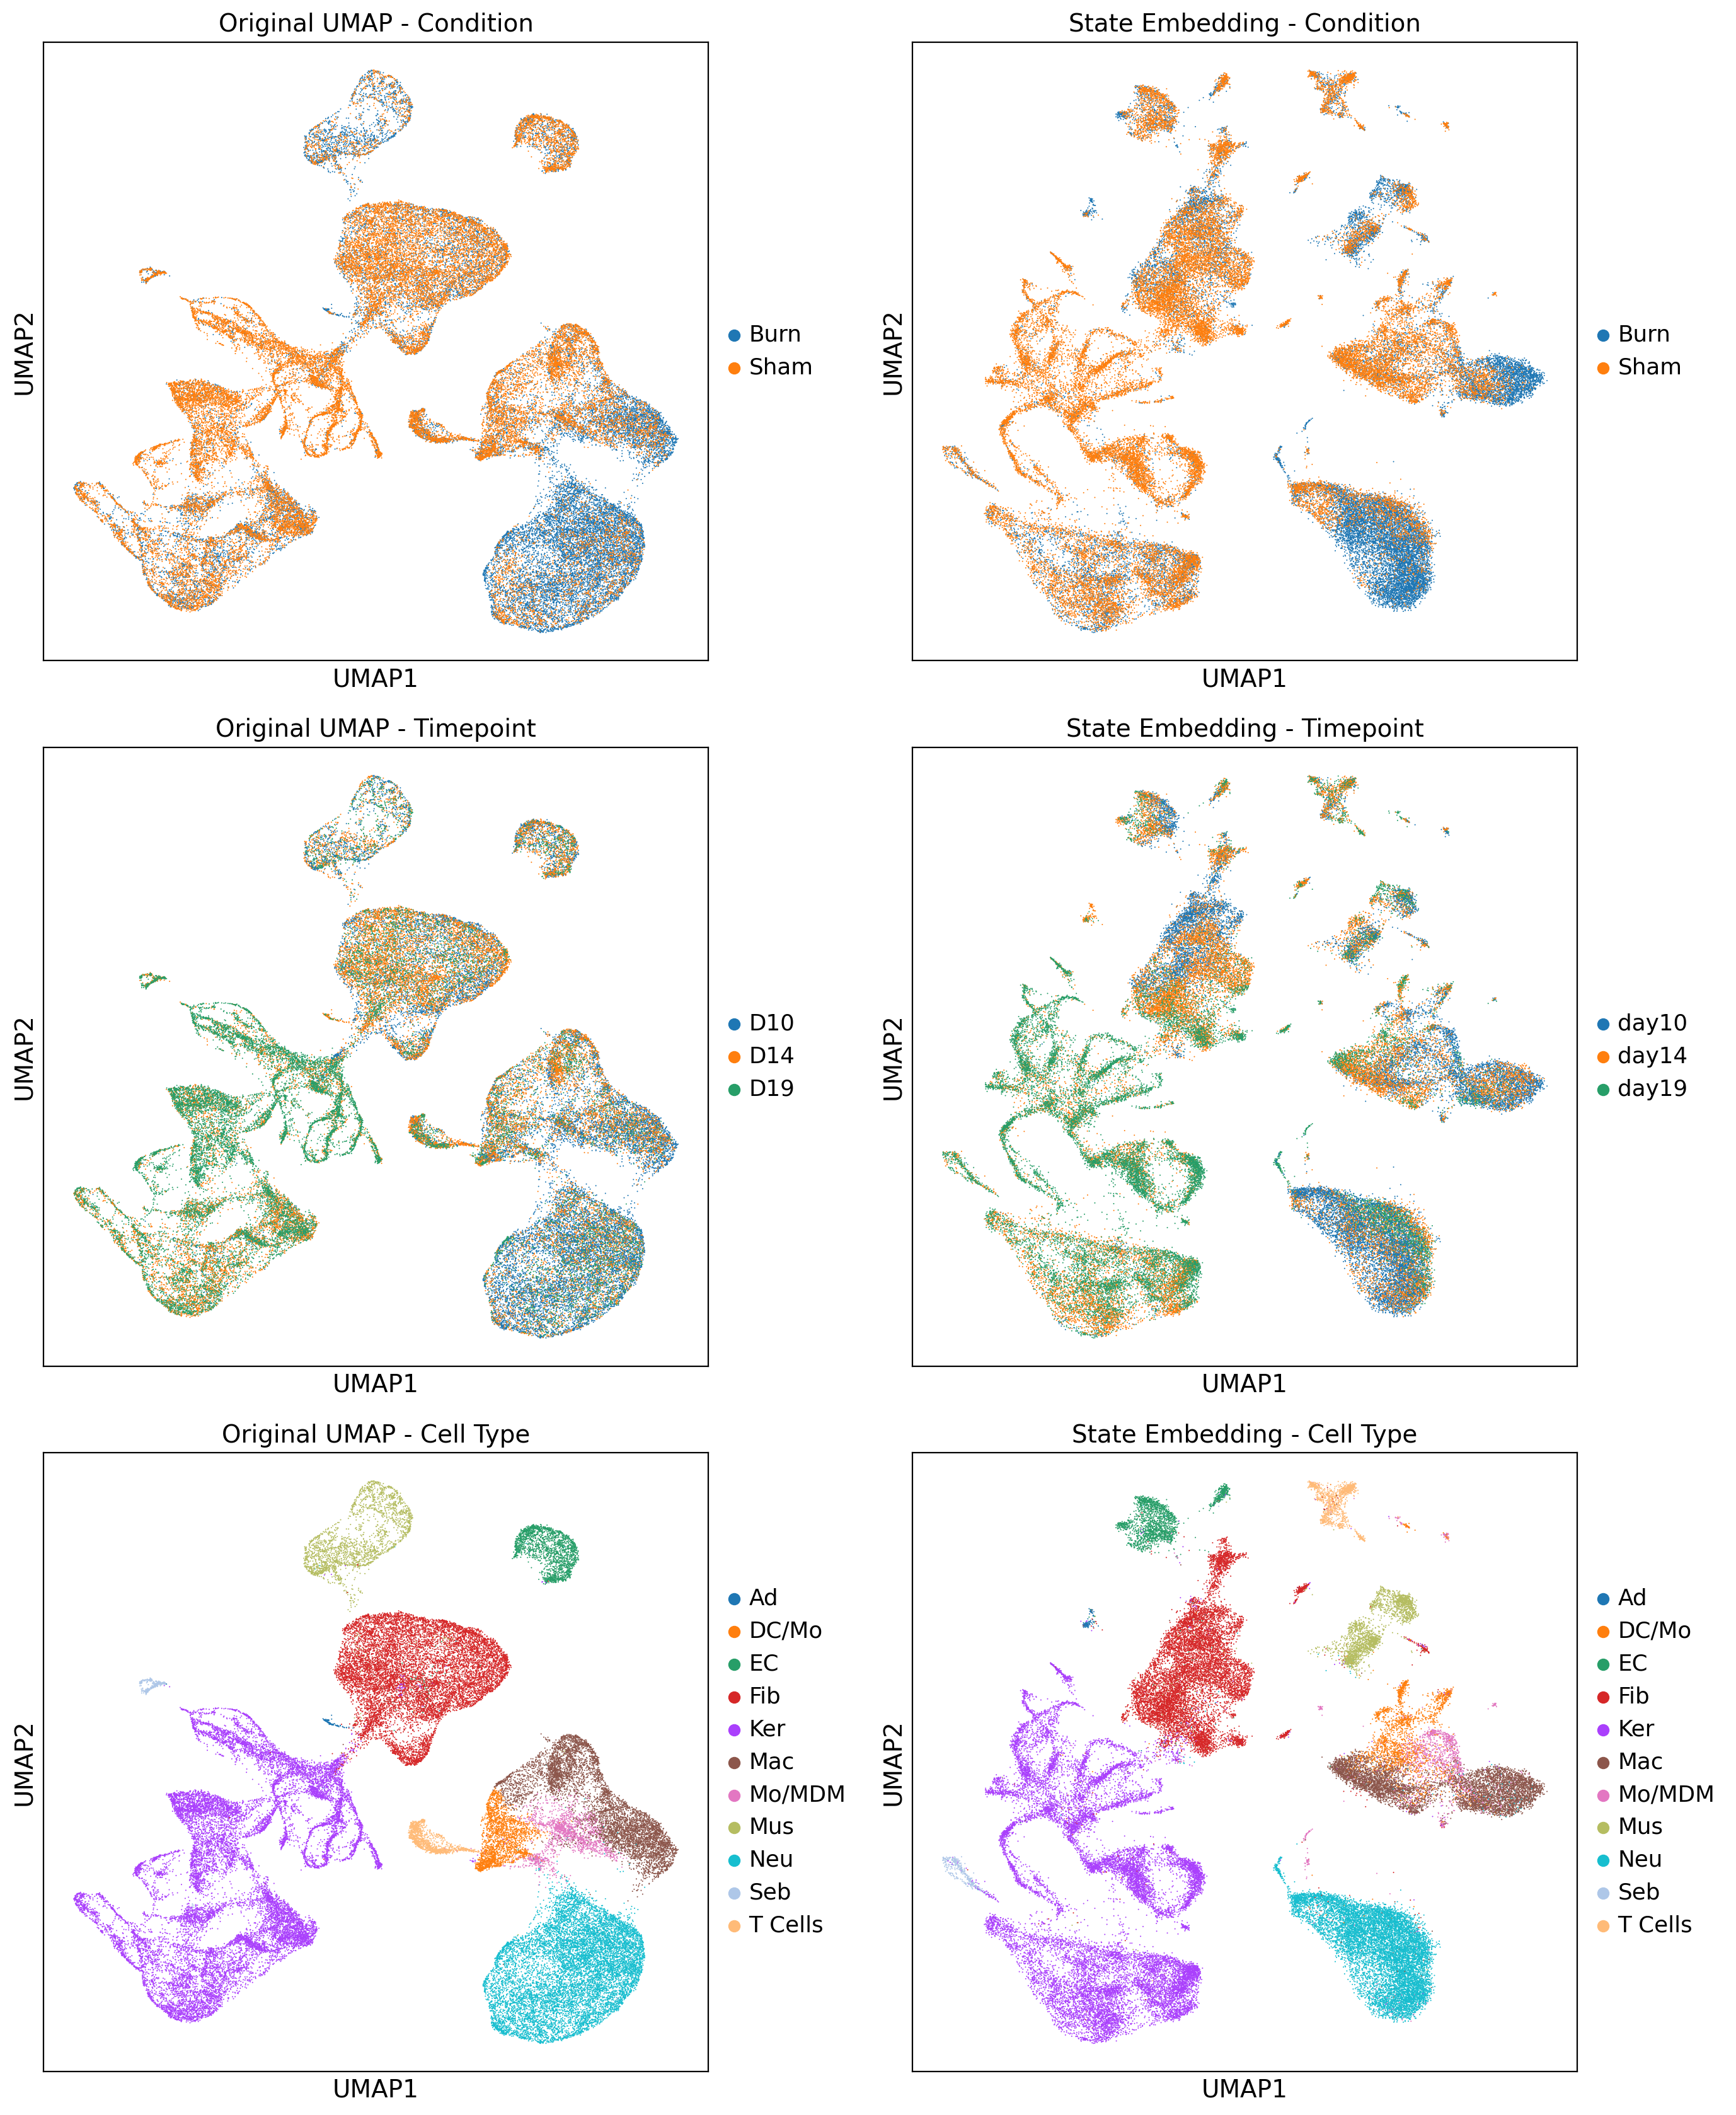

In [ ]:
# Create comprehensive side-by-side comparison
fig, axes = plt.subplots(3, 2, figsize=(14, 17))

# Row 1: Condition (Burn/Sham)
sc.pl.embedding(adata_orig, basis='umap', color='Type',
                ax=axes[0,0], show=False, title='Original UMAP - Condition')
sc.pl.umap(adata, color='condition',
           ax=axes[0,1], show=False, title='State Embedding - Condition')

# Row 2: Timepoint
sc.pl.embedding(adata_orig, basis='umap', color='Timepoint',
                ax=axes[1,0], show=False, title='Original UMAP - Timepoint')
sc.pl.umap(adata, color='timepoint',
           ax=axes[1,1], show=False, title='State Embedding - Timepoint')

# Row 3: Cell Type
sc.pl.embedding(adata_orig, basis='umap', color='cell_types_simple_short',
                ax=axes[2,0], show=False, title='Original UMAP - Cell Type',
                legend_loc='right margin')

sc.pl.umap(adata, color='cell_types_simple_short',
           ax=axes[2,1], show=False, title='State Embedding - Cell Type',
           legend_loc='right margin')


plt.tight_layout()
plt.savefig('original_vs_state_comparison.png', dpi=300, bbox_inches='tight')
plt.show()